<a href="https://colab.research.google.com/github/hchristiaan/TrainCNN4SignatureVerification/blob/master/ProjectCode_Base_seed30.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Please note that:
#     # - Means comment explaining the code
#     ### - Means things that need to be addressed

In [0]:
from google.colab import auth
auth.authenticate_user()

import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
email = gcloud_tokeninfo['email']
username = email.split('@')[0]
print(username)

hchr147


In [0]:
# Import all required repositories for the project
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
import keras.backend as K
import tensorflow as tf
from keras import applications
from keras.models import Model
from keras.layers import Flatten, Dense, Input,concatenate
from keras.optimizers import Adam
from keras.models import load_model, model_from_json

import random

Using TensorFlow backend.


In [0]:
# Import the google drive to upload the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import datetime

now = datetime.datetime.now()
date = now.strftime("%Y%m%d%H%M")

print(date)



201906020721


In [0]:
# Unzip the image dataset
!unzip '/content/drive/Team Drives/inputdataset/UTSig.zip' -d /content

Archive:  /content/drive/Team Drives/inputdataset/UTSig.zip
   creating: /content/UTSig/Forgery/
   creating: /content/UTSig/Forgery/Opposite Hand/
   creating: /content/UTSig/Forgery/Opposite Hand/1/
  inflating: /content/UTSig/Forgery/Opposite Hand/1/1.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/1/2.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/1/3.tif  
   creating: /content/UTSig/Forgery/Opposite Hand/10/
  inflating: /content/UTSig/Forgery/Opposite Hand/10/1.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/10/2.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/10/3.tif  
   creating: /content/UTSig/Forgery/Opposite Hand/100/
  inflating: /content/UTSig/Forgery/Opposite Hand/100/1.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/100/2.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/100/3.tif  
   creating: /content/UTSig/Forgery/Opposite Hand/101/
  inflating: /content/UTSig/Forgery/Opposite Hand/101/1.tif  
  inflating: /content/UT

In [0]:
# Proposed file restructing to fit this code
import os, shutil

filePath = '/content/UTSig'

filePathGen = filePath + '/Genuine'
filePathFor = filePath + '/Forgery'
filePathForSk = filePath + '/Forgery/Skilled' 
filePathForOh = filePath + '/Forgery/Opposite Hand' 
filePathForSi = filePath + '/Forgery/Simple' 

if "Simple" in os.listdir(filePathFor):
  if "1" in os.listdir(filePathGen):
      for i in os.listdir(filePathGen):
          author = i
          for j in os.listdir(filePathGen + '/' + author):
              os.rename(filePathGen + '/' + author + "/" + j, filePathGen + "/" + "g_" + author + "_" + j)
          os.removedirs(filePathGen + "/" + author)

  if "Skilled" in os.listdir(filePathFor):
      for i in os.listdir(filePathForSk):
          author = i
          for j in os.listdir(filePathForSk + '/' + author):
              os.rename(filePathForSk + '/' + author + "/" + j, filePathFor + "/" + "fSk_" + author + "_" + j)
          os.removedirs(filePathForSk + "/" + author)

  if "Opposite Hand" in os.listdir(filePathFor):
      for i in os.listdir(filePathForOh):
          author = i
          for j in os.listdir(filePathForOh + '/' + author):
              os.rename(filePathForOh + '/' + author + "/" + j, filePathFor + "/" + "fOh_" + author + "_" + j)
          os.removedirs(filePathForOh + "/" + author)

  #if "Simple" in os.listdir(filePathFor):
   #   shutil.rmtree(filePathForSi)
      
  if "Simple" in os.listdir(filePathFor):
    for i in os.listdir(filePathForSi):
        author = i
        count = 1
        for j in os.listdir(filePathForSi + '/' + author):
            os.rename(filePathForSi + '/' + author + "/" + j, filePathFor + "/" + "fSi_" + author + "_" + str(count) + ".tif")
            count = count + 1
        os.removedirs(filePathForSi + "/" + author)


In [0]:
### Need code for altering .tif files into .png? or can we go ahead and just work with .tif? ###

In [0]:
# File paths of the image data used later in the project
### Need to discuss how we will seperate our data. 80% 20% rule? ###
gentr="/content/UTSig/Genuine"
forgtr="/content/UTSig/Forgery"

gent="/content/UTSig/Genuine"
forgt="/content/UTSig/Forgery"

In [0]:
# Code block for working with the image files (resizing, retreiving files, etc.)

# Standard height weight for images
img_width, img_height, channels = 224, 224, 3

dim = (img_width, img_height)

# Converts the images to rgb which is what VGG-16 takes as input
def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb


# Takes in file path and image name and returns resized image
def returnimages(path,img):
    image=cv2.imread(path+"/"+ img)                  #bringing the image
    image=cv2.resize(image, (img_width, img_height))
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=to_rgb(image).reshape(1,img_width, img_height,3)/255.0       #resizing and normalizing    
    return image     

# Takes in number of author, path for genuine and forged signatures
# Returns one image name (m.pop()), and two arrays of file names n = forgary, m = genuine
# Used for generator()
def getfiles(num,gen,forg):
    genList=os.listdir(gen)
    forgList=os.listdir(forg)
    author=str(num)
    print(author)
           
    forgArr,genArr=[],[]
    for i in forgList:
        if ("_" + author + "_") in i:
            forgArr = forgArr + [i]
            
    for i in genList:
        if ("_" + author + "_") in i:
            genArr = genArr + [i]
     
    return genArr.pop(), forgArr, genArr
######################################

# Same as getfiles but returns two files
def getfilest(num,gen,forg):
    genList=os.listdir(gen)
    forgList=os.listdir(forg)
    author=str(num)
           
    forgArr,genArr=[],[]
    for i in forgList:
        if ("_" + author + "_") in i:
            forgArr = forgArr + [i]
            
    for i in genList:
        if ("_" + author + "_") in i:
            genArr = genArr + [i]

    return genArr.pop(), genArr.pop(), forgArr, genArr

In [0]:
# creating 3 fold cross-validations

#print(validation_set)
random.seed(30)

sigIndex = list(range(1,116))
random.shuffle(sigIndex)

folds = [sigIndex[0:30],sigIndex[30:60],sigIndex[60:90]]
test =sigIndex[90:116]
train1 = list(set(folds[0]+folds[1]))
train2 = list(set(folds[1]+folds[2]))
train3 = list(set(folds[0]+folds[2]))
train = [train1,train2,train3]
valid = [folds[2],folds[0], folds[1]]

In [0]:
# Function for defining loss variable in model, leave for now, look into altering?
### Unsure what y_pred is doing, or how this works....
def triplet_loss(y_true, y_pred):
    alpha = 0.5
    anchor, positive, negative =y_pred[0,0:512], y_pred[0,512:1024], y_pred[0,1024:1536]
    print(str(anchor), str(positive), str(negative))
    print(str(y_true), str(y_pred))
    
    positive_distance = K.mean(K.square(anchor - positive),axis=-1)
    negative_distance = K.mean(K.square(anchor - negative),axis=-1)
    return K.mean(K.maximum(0.0, positive_distance - negative_distance + alpha))

In [0]:
# Defining the architecture. chose to go with 16 as it is smaller...
#model = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='max')

### Imput baseline model ### Unsure how this is done, commenting for now
baseModel = applications.vgg16.VGG16(weights=None, include_top=False, pooling='max')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# For layers from 1 to 15 freeze the weights

### We will need to do a test for each layer to find the optimal transfer* ###
### For now just copying over the code from example
#for layer in model.layers[:5]:
#    layer.trainable = False
baseModel.trainable = True

In [0]:
# all "in" variables are defining the input "shape" for the model
# Input is a function in Keras
# Positive represents genuine / Negative represents Forgary 
anchor_in = Input(shape=(img_width, img_height, channels))
pos_in = Input(shape=(img_width, img_height, channels))
neg_in = Input(shape=(img_width, img_height, channels))

# Defining output of model
anchor_out = baseModel(anchor_in)
pos_out = baseModel(pos_in)
neg_out = baseModel(neg_in)
merged_vector = concatenate([anchor_out, pos_out, neg_out],axis=1)

In [0]:
# Setting inputs and outputs of the model
# Model function - potentially overwrites the input and output layers
### Unsure what the output is... Need to research ###
# Input is 3 images: image in question (anchor), postitive image, negative image (same authors)

#model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
baseModel = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)

In [0]:
# Compiling the model
# loss function set to function defined earlier
# Optimizer is for learning rate of the function
### unsure what Adam function does

#model.compile(optimizer=Adam(lr=0.000005),loss=triplet_loss)
baseModel.compile(optimizer=Adam(lr=0.00001),loss=triplet_loss) #,metrics=['accuracy'])

Tensor("loss/concatenate_1_loss/strided_slice:0", shape=(512,), dtype=float32) Tensor("loss/concatenate_1_loss/strided_slice_1:0", shape=(512,), dtype=float32) Tensor("loss/concatenate_1_loss/strided_slice_2:0", shape=(512,), dtype=float32)
Tensor("concatenate_1_target:0", shape=(?, ?), dtype=float32) Tensor("concatenate_1/concat:0", shape=(?, 1536), dtype=float32)


In [0]:
baseModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 512)          14714688    input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [0]:
#len(baseModel.trainable_variables)
path = "/content/drive/Team Drives/results/" + username + "/" + date + "/"
os.mkdir(path)
baseModel.save_weights(path + 'initial_weights.h5')

In [0]:
# Generator - Goes through every author (in test) and returns an anchor (last image) and an array of file names (negative=forged) (positive=genuine) 
def generator(x):
  #  for i in range(1,96):
    print("Training " + str(x))
    for i in x:
      # Returns last genuine image, array of pos/genuine files, array of neg/forgary files
        anc,neg,pos=getfiles(i,gentr,forgtr)
        
#When we have the list of images/arrays for that author, we then loop through for the length of the negative list (total number of forged)
  #For each negative image, we are going to loop through the length of the positive list
    #For each positive image we resize the anchor, first
    
        for i in range(len(neg)):           
            for j in range(len(pos)):        
                anchor=returnimages(gentr,anc)
                positive=returnimages(gentr,pos[j])
                negative=returnimages(forgtr,neg[i])
               # yield ([anc,pos[j],neg[i]],[0])
                yield ([anchor,positive,negative],[0])

In [0]:
# Generator - Goes through every author (in test) and returns an anchor (last image) and an array of file names (negative=forged) (positive=genuine) 
def generator_validator(x):
    print("Validation " + str(x))
    for i in x:
      # Returns last genuine image, array of pos/genuine files, array of neg/forgary files
        anc,neg,pos=getfiles(i,gentr,forgtr)
        
#When we have the list of images/arrays for that author, we then loop through for the length of the negative list (total number of forged)
  #For each negative image, we are going to loop through the length of the positive list
    #For each positive image we resize the anchor, first
    
        for i in range(len(neg)):           
            for j in range(len(pos)):        
                anchor=returnimages(gentr,anc)
                positive=returnimages(gentr,pos[j])
                negative=returnimages(forgtr,neg[i])
               # yield ([anc,pos[j],neg[i]],[0])
                yield ([anchor,positive,negative],[0])

In [0]:
### These values were taken from example, need to decide on what they should be
#print("Starting our model:")
#for x in range(2):
   # print("Iteration: " + str(x))
   #model.fit_generator(generator(),steps_per_epoch=200,epochs=3)
    
logs = ["training1.log", "training2.log", "training3.log"]
weights = ["model_weights_1.h5", "model_weights_2.h5", "model_weights_3.h5"]

print("Starting the base model:")
#for i in range(3):
i = 0
print("Iteration: " + str(i))
#initial_weights = path + "initial_weights.h5"
  #baseModel.load_weights(initial_weights)
  #baseModel.trainable = True
weight = path + weights[i]
log = path + logs[i]
csv = keras.callbacks.CSVLogger(log)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto', baseline=.48, restore_best_weights=True)
  #es_list = [es, csv]
cb_list = [es, csv]
#history = baseModel.fit_generator(generator(),steps_per_epoch=200,epochs=10,callbacks= es_list,validation_data=generator_validator(),validation_steps=5)
history = baseModel.fit_generator(generator(train[i]),steps_per_epoch=200,epochs=90,callbacks = cb_list, validation_data=generator_validator(valid[i]),validation_steps=100)
baseModel.save_weights(weight)
  





Starting the base model:
Iteration: 0
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/90
Training [3, 5, 6, 12, 14, 16, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 34, 35, 37, 39, 42, 43, 44, 46, 47, 48, 53, 54, 56, 57, 58, 59, 61, 62, 63, 66, 74, 75, 76, 78, 85, 86, 87, 88, 89, 91, 92, 93, 94, 97, 98, 99, 103, 105, 107, 110, 113, 114, 115]Validation [2, 50, 8, 41, 102, 101, 100, 65, 108, 71, 112, 17, 40, 64, 15, 72, 81, 13, 82, 55, 36, 73, 96, 95, 90, 9, 69, 45, 109, 52]

2
3
200/200 [==============================] - 29s 143ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 2/90
200/200 [==============================] - 22s 112ms/step - loss: 0.3803 - val_loss: 0.6478
Epoch 3/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0099 - val_loss: 0.8941
Epoch 4/90
200/200 [==============================] - 22s 111ms/step - loss: 0.0176 - val_loss: 0.6729
Epoch 5/90
200/200 [===========

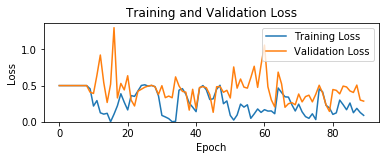

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#history = baseModel.fit_generator(generator(),steps_per_epoch=200,epochs=110)

In [0]:
#history = baseModel.fit_generator(generator(),steps_per_epoch=200,epochs=110)

In [0]:
### Unsure purpose of this part ###

# used for validation

tneg,tpos = 0, 0
# Uses values not used in generator 2 to validate
x= range(93,116)
print(test)

for k in test: #the id of signatures you want to check
    #print("When k is ", k)
    anc,neg,pos=getfiles(k,gent,forgt)
    tneg=tneg+len(neg)
    tpos=tpos+len(pos)
print("Forgary Image Total: " + str(tneg),"Genuine Image Total: " + str(tpos))

[68, 77, 21, 10, 111, 32, 67, 1, 60, 11, 18, 83, 49, 51, 7, 33, 27, 106, 84, 80, 4, 79, 38, 104, 70]
68
77
21
10
111
32
67
1
60
11
18
83
49
51
7
33
27
106
84
80
4
79
38
104
70
Forgary Image Total: 1125 Genuine Image Total: 650


In [0]:
#os.listdir('/content')

In [0]:
### Code for base model - duplicated with variables changed ###
#for i in range(3):
i = 0
print("Iteration: " + str(i))
#weight = path + weights[i]
#baseModel.load_weights(weight)
  
forg_passed=0
gen_flagged=0

for k in test: #the id of signatures you want to check
    print("When k is ", k)
    anc,neg,pos=getfiles(k,gent,forgt)
    
    anchor=returnimages(gent,anc)
    for i in range(len(pos)): #pos
        positive=returnimages(gent,pos[i])
        x=baseModel.predict([anchor,positive,anchor])
        a, p, useless = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-p)
        dist=np.linalg.norm(a-p)
        #print("positive distance is ",dist)
        if(dist>32):
        #  print("0")
            gen_flagged=gen_flagged+1
            print("gen flagged - ",dist, "file name is - ", pos[i])
            
        else:
            gen_flagged=gen_flagged
        #   print("1")
        
    for j in range(len(neg)): #neg
        negative=returnimages(forgt,neg[j])
        x=baseModel.predict([anchor,negative,anchor])
        a, n, useless = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-n)
        dist=np.linalg.norm(a-n)
        #print("negative distance is ",dist)
        if(dist>32):
            forg_passed=forg_passed
          #  print("0")
        else:
            forg_passed=forg_passed+1
            print("forg passed - ",dist, "file name is - ", neg[j])
          #  print("1")

print("base_forg_passed is ",forg_passed)
print("base_gen_flagged is ",gen_flagged)
print("False Acceptance Rate (FAR) = ", str(100*forg_passed/tneg), "%")
print("False Rejection Rate (FRR) = ", str(100*gen_flagged/tpos), "%")

Iteration: 0
When k is  68
68
gen flagged -  32.31163 file name is -  g_68_23.tif
forg passed -  9.882348 file name is -  fSi_68_26.tif
forg passed -  10.962776 file name is -  fSi_68_19.tif
forg passed -  9.853819 file name is -  fSi_68_27.tif
forg passed -  15.033149 file name is -  fSi_68_34.tif
forg passed -  15.770829 file name is -  fSi_68_22.tif
forg passed -  10.715668 file name is -  fSi_68_11.tif
forg passed -  21.72974 file name is -  fSi_68_36.tif
forg passed -  15.49114 file name is -  fSi_68_31.tif
forg passed -  27.816442 file name is -  fSk_68_6.tif
forg passed -  20.746487 file name is -  fSi_68_14.tif
forg passed -  24.530409 file name is -  fSi_68_30.tif
forg passed -  19.362957 file name is -  fSi_68_8.tif
forg passed -  10.117555 file name is -  fSi_68_20.tif
forg passed -  16.036453 file name is -  fSi_68_25.tif
forg passed -  17.41669 file name is -  fOh_68_2.tif
forg passed -  7.1819096 file name is -  fSi_68_17.tif
forg passed -  15.086301 file name is -  fSi_6

In [0]:
### This is the code for the base model - duplicated with variables changed ###
#for i in range(3):
  i = 0
  print("Iteration: " + str(i))
  #weight = path + weights[i]
  #baseModel.load_weights(weight)
  
  forg_passed=0
  gen_flagged=0

  for k in test: #the id of signatures you want to check
    print("When k is ", k)
    anc1,anc2,neg,pos=getfilest(k,gent,forgt)
    
    anchor1=returnimages(gent,anc1)
    anchor2=returnimages(gent,anc2)
    for i in range(len(pos)): #pos
        positive=returnimages(gent,pos[i])
        x=baseModel.predict([anchor1,positive,anchor2])
        a1, p, a2 = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-p)
        
        #Taking two distances (two anchor images), and taking average between the two
        dist1=np.linalg.norm(a1-p)
        dist2=np.linalg.norm(a2-p)
        dist=(dist1+dist2)/2
        #print("positive distance is ",dist)
        if(dist>32):
        #  print("0")
            gen_flagged=gen_flagged+1
            print("gen flagged - ",dist, "file name is - ", pos[i])
            
        else:
            gen_flagged=gen_flagged
        #   print("1")
        
    for j in range(len(neg)): #neg
        negative=returnimages(forgt,neg[j])
        x=baseModel.predict([anchor1,negative,anchor2])
        a1, n, a2 = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-n)
        dist1=np.linalg.norm(a1-n)
        dist2=np.linalg.norm(a2-n)
        #print("negative distance is ",dist)
        dist=(dist1+dist2)/2
        if(dist>32):
            forg_passed=forg_passed
          #  print("0")
        else:
            forg_passed=forg_passed+1
            print("forg passed - ",dist, "file name is - ", neg[j])
          #  print("1")

  print("base_forg_passed is ",forg_passed)
  print("base_gen_flagged is ",gen_flagged)
  print("False Acceptance Rate (FAR) = ", str(100*forg_passed/tneg), "%")
  print("False Rejection Rate (FRR) = ", str(100*gen_flagged/tpos), "%")


Iteration: 0
When k is  68
forg passed -  29.1103515625 file name is -  fSi_68_2.tif
forg passed -  13.223434448242188 file name is -  fSi_68_26.tif
forg passed -  17.15555763244629 file name is -  fSi_68_19.tif
forg passed -  11.434042930603027 file name is -  fSi_68_27.tif
forg passed -  20.063549041748047 file name is -  fSi_68_34.tif
forg passed -  16.937297821044922 file name is -  fSi_68_22.tif
forg passed -  15.84332275390625 file name is -  fSi_68_11.tif
forg passed -  20.493825912475586 file name is -  fSi_68_36.tif
forg passed -  20.270429611206055 file name is -  fSi_68_31.tif
forg passed -  29.070297241210938 file name is -  fSk_68_6.tif
forg passed -  25.15308380126953 file name is -  fSi_68_14.tif
forg passed -  22.859943389892578 file name is -  fSi_68_30.tif
forg passed -  22.775470733642578 file name is -  fSi_68_8.tif
forg passed -  11.742799758911133 file name is -  fSi_68_20.tif
forg passed -  17.98651885986328 file name is -  fSi_68_25.tif
forg passed -  15.8062496